In [4]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras
!pip install dm-reverb[tensorflow]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,684 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [3]:

# First uninstall problematic packages
!pip uninstall -y jax jaxlib tensorflow tf-agents dm-reverb numpy

# Then install known-good versions
!pip install numpy==1.23.5  # Stable version compatible with TF/JAX
!pip install "jax[cuda12_pip]==0.4.23" "jaxlib==0.4.23"  # Matching versions
!pip install tensorflow==2.15.1
!pip install dm-reverb==0.14.0
!pip install tf-agents[reverb]==0.19.0

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
ERROR: Operation cancelled by user
INFO: pip is looking at multiple versions of jax[cuda12-pip] to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install jax[cuda12-pip]==0.4.23 and jaxlib==0.4.23 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested jaxlib==0.4.23
    jax[cuda12-pip] 0.4.23 depends on jaxlib==0.4.23+cuda12.cudnn89; extra == "cuda12-pip"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to

In [2]:
!pip install dm-reverb==0.14.0 tensorflow==2.15.1 tf-agents[reverb]==0.19.0

In [3]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [5]:
!pip install pyvirtualdisplay

In [2]:
import reverb
import base64
import imageio
import IPython
import matplotlib
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

ModuleNotFoundError: No module named 'reverb'

In [7]:
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec  # Add the missing import
from tf_agents.utils import common


In [8]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

tf.version.VERSION

FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb'

# Hyperparameter

In [9]:
# ======================
# Hyperparameters
# ======================
learning_rate = 1e-4              # Smaller LR for stability
num_iterations = 30000            # Increased training iterations
sequence_length = 2               # N-step learning
initial_collect_steps = 2000      # More initial random experience
collect_steps_per_iteration = 2   # Experience collection rate
replay_buffer_max_length = 200000 # Larger replay buffer
batch_size = 64                   # Balanced batch size
gamma = 0.99                      # Discount factor
target_update_period = 200        # Target network update frequency

# Evaluation parameters
num_eval_episodes = 50           # Full 50-episode evaluations
eval_interval = 500              # Evaluate every 500 steps
log_interval = 200               # Log progress every 200 steps


# Environment

In [10]:
# Environment Setup
# ======================
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)



In [11]:
# Determine number of actions based on the action specification of the environment
action_tensor_spec = env.action_spec()
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [12]:
# Enhanced Network Architecture
# ======================
dense_layers = [
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')
]

q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [13]:
# Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)
# Slower epsilon decay with minimum exploration
epsilon_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,    # Start with 100% random actions
    decay_steps=num_iterations,   # Decay over full training
    end_learning_rate=0.05,       # Keep 5% exploration at end
    power=0.5)                    # Slower decay curve

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [14]:
# ======================
# Policies
# ======================
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec())

In [15]:
# Evaluation Metrics
# ======================
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    successes = 0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        step_count = 0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            step_count += 1

        total_return += episode_return
        if step_count >= 200:  # Count as success if lasts 200+ steps
            successes += 1

    avg_return = total_return / num_episodes
    success_rate = successes / num_episodes
    return avg_return.numpy()[0], success_rate

In [16]:
# ======================
# Prioritized Replay Buffer
# ======================
table_name = 'prioritized_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Prioritized(0.6),  # Prioritized experience replay
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(batch_size),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=sequence_length,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=sequence_length)

In [17]:
# ======================
# Initial Data Collection
# ======================
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

# Dataset with prioritized sampling
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=sequence_length).prefetch(3)

iterator = iter(dataset)

In [18]:
# ======================
# Training Loop
# ======================
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)


<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [19]:
# Tracking variables
returns = []
success_rates = []
losses = []
consecutive_successes = 0
best_success_rate = 0

time_step = train_py_env.reset()
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

In [20]:
for step in range(num_iterations):
    # Collect experience
    time_step, _ = collect_driver.run(time_step)

    # Train on batch
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    # Evaluation and logging
    if step % eval_interval == 0:
        avg_return, success_rate = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        returns.append(avg_return)
        success_rates.append(success_rate)
        losses.append(train_loss.numpy())

        print(f'step = {step}: loss = {train_loss:.4f}, '
              f'avg_return = {avg_return:.2f}, '
              f'success_rate = {success_rate:.2f}')

        # Early stopping condition
        if success_rate >= 0.98:  # 98% success in evaluation
            consecutive_successes += 1
            if consecutive_successes >= 3:  # 3 consecutive evaluations
                print(f"Early stopping at step {step} - "
                      f"consistent success achieved!")
                break
        else:
            consecutive_successes = 0

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 0: loss = 1.2146, avg_return = 48.64, success_rate = 0.00
step = 500: loss = 3.4878, avg_return = 47.06, success_rate = 0.00
step = 1000: loss = 65.2360, avg_return = 62.32, success_rate = 0.00
step = 1500: loss = 38.7989, avg_return = 74.50, success_rate = 0.00
step = 2000: loss = 33.5084, avg_return = 82.84, success_rate = 0.00
step = 2500: loss = 30.7205, avg_return = 102.16, success_rate = 0.00
step = 3000: loss = 19.7886, avg_return = 167.02, success_rate = 0.38
step = 3500: loss = 25.3933, avg_return = 200.00, success_rate = 1.00
step = 4000: loss = 20.3849, avg_return = 200.00, success_rate = 1.00
step = 4500: loss = 119.5017, avg_return = 178.48, success_rate = 0.30
step = 5000: loss = 38.5414, avg_return = 173.10, success_rate = 0.22
step = 5500: loss = 112.1648, avg_return = 200.00, success_rate = 1.00
step = 6000: loss = 29.0855, avg_return = 200.00, success_rate = 1.00
step = 6500: loss = 137.8458, avg_return = 200.00, success_rate = 1.00
Early stopping at step 6500 

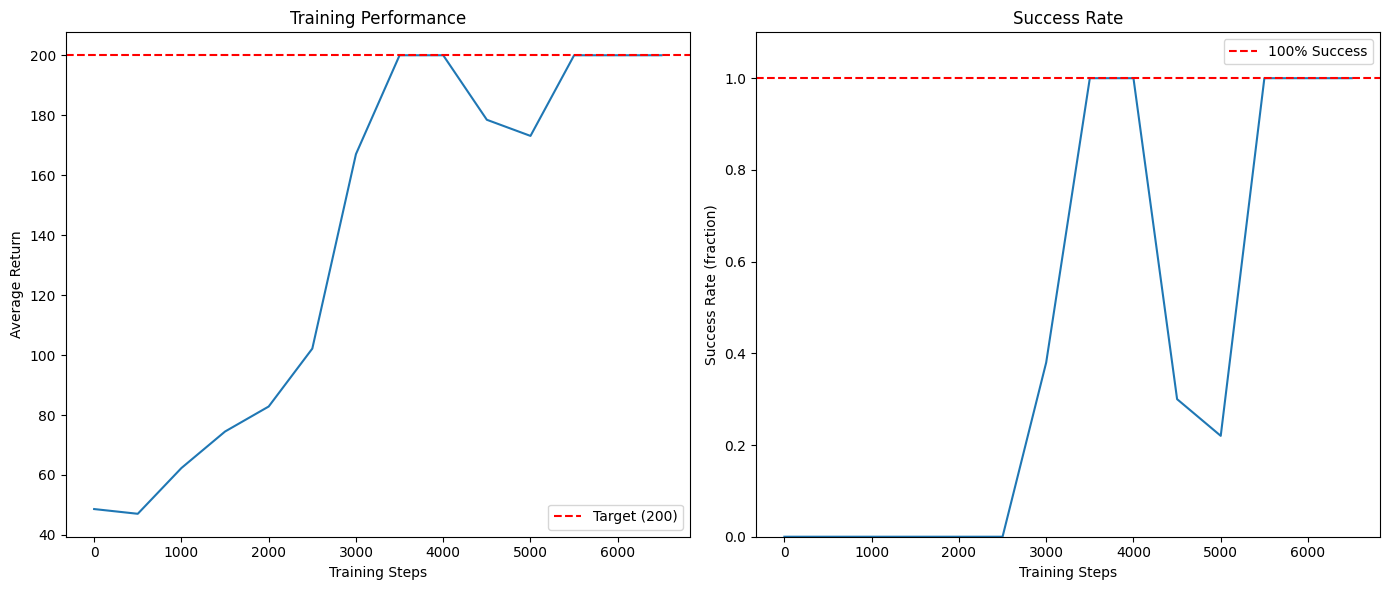

In [22]:
# ======================
# Results Visualization
# ======================
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

# Plot 1: Average Return
plt.subplot(1, 2, 1)
steps = range(0, len(returns)*eval_interval, eval_interval)
plt.plot(steps, returns)
plt.title('Training Performance')
plt.xlabel('Training Steps')
plt.ylabel('Average Return')
plt.axhline(y=200, color='r', linestyle='--', label='Target (200)')
plt.legend()

# Plot 2: Success Rate
plt.subplot(1, 2, 2)
plt.plot(steps, success_rates)
plt.title('Success Rate')
plt.xlabel('Training Steps')
plt.ylabel('Success Rate (fraction)')
plt.axhline(y=1.0, color='r', linestyle='--', label='100% Success')
plt.ylim(0, 1.1)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Final Evaluation
final_avg_return, final_success_rate = compute_avg_return(
    eval_env, agent.policy, 50)
print("\n=== Final Evaluation ===")
print(f"Average Return over 50 episodes: {final_avg_return:.2f}")
print(f"Success Rate (200+ steps): {final_success_rate:.2f}")



=== Final Evaluation ===
Average Return over 50 episodes: 200.00
Success Rate (200+ steps): 1.00


In [29]:
import os
import pygame

# Before rendering, initialize Pygame and set SDL to use the dummy display
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.display.init()

In [30]:
# Render trained agent
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)
print("\nTrained Agent Performance:")
create_policy_eval_video(agent.policy, "trained-agent")

print("\nRandom Policy Performance:")
create_policy_eval_video(random_policy, "random-agent")



Trained Agent Performance:



Random Policy Performance:



Trained Agent Performance:


NameError: name 'create_policy_eval_video' is not defined